In this lab you will do the following steps in order:

1. Load a new dataset using ``torchvision dataloader``
2. Perform transfer learning of a pre-trained NN (Neural Network)





Useful resources:

* [dataloader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)
*   [network layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [activation function](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [loss functions](https://pytorch.org/docs/stable/nn.html#convolution-layers)






Use GPU if available

In [1]:
import torch
import glob  # Import library for finding all files matching a pattern
from PIL import Image  # Import library for image processing
import numpy as np  # Import library for numerical operations (not used here)
import os  # Import library for operating system functionalities
from tqdm import tqdm  # Import library for displaying progress bar

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Data preparation

In [2]:
# #download images
# !wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
# #download metadata
# !wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_meta.tar
# #extract
# !tar -xf imdb_crop.tar
# !tar -xf imdb_meta.tar

In [3]:
# # move to data folder
# !mv imdb/ data/
# !mv imdb_crop/ data/

Remove grayscale images

In [4]:
# # Define a path pattern to search for all jpg images within subdirectories of "data/imdb_crop"
# image_path_pattern = "data/imdb_crop/*/*.jpg"

# # Find all image file paths matching the pattern
# image_paths = glob.glob(image_path_pattern)

# imgs_removed = 0
# # Iterate through each image path
# for image_path in tqdm(image_paths):
#   # Open the image using Pillow's Image class
#   image = Image.open(image_path)

#   # Get the number of color channels in the image (e.g., RGB has 3 channels)
#   num_channels = len(image.getbands())

#   # Check if the image has a different number of channels than expected (likely grayscale or unsupported format)
#   if num_channels != 3:
#     # If not 3 channels, remove the image file
#     os.remove(image_path)
#     # print(f"Removed {image_path} (not RGB format)")  # Print statement to show removed files
#     imgs_removed += 1

# print(f"Removed {imgs_removed} images") ### --> Removed 22532 images

Define function to convert numeric date to common date format

In [5]:
from datetime import datetime, timedelta  # Import libraries for date and time manipulation

def datenum_to_datetime(datenum):
  """
  Converts a date represented as a floating-point number (Excel-style) to a Python datetime object.

  Args:
      datenum (float): The date represented as a floating-point number.

  Returns:
      datetime: The converted datetime object (year only if conversion fails).
          If conversion fails due to ValueError, TypeError, or OverflowError,
          returns np.nan.
  """

  try:
    # Extract components from the datenum
    days = datenum % 1  # Extract days (decimal part)
    hours = days % 1 * 24  # Extract hours from remaining decimal part
    minutes = hours % 1 * 60  # Extract minutes from remaining decimal part
    seconds = minutes % 1 * 60  # Extract seconds from remaining decimal part

    # Convert to datetime object with separate day, hour, minute, and second components
    exact_date = (datetime.fromordinal(int(datenum))  # Convert integer part to date
                 + timedelta(days=int(days))  # Add extracted days
                 + timedelta(hours=int(hours))  # Add extracted hours
                 + timedelta(minutes=int(minutes))  # Add extracted minutes
                 + timedelta(seconds=round(seconds)))  # Add extracted seconds (rounded)

    # Adjust for Excel's epoch being different from standard epoch (correct for year)
    exact_date -= timedelta(days=366)

    # Return the year from the converted datetime object
    return exact_date.year

  except (ValueError, TypeError, OverflowError) as e:
    return np.nan  # Return np.nan if conversion fails


Define the [dataloader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class) class

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import scipy
import torch
import collections

class FacesDataset(Dataset):
      """Face Landmarks dataset.

      This class loads and preprocesses a dataset of face images with corresponding ages.
      It supports train, validation, and test splits.
      """

      def __init__(self, root_dir, transform, split):
        """
        Args:
            root_dir (string): Directory containing the images.
            transform (callable, optional): Transformation to be applied to the images.
            split (string): Split type ("train", "val", or "test").
        """
        self.split=split
        self.root_dir = root_dir
        self.data = self.get_data()  # Load and preprocess data
        total_data_len = int(len(self.data) * 0.5)  # Select small portion of the dataset

        # Randomly shuffle indices for train/val/test split
        idx = np.arange(total_data_len)
        np.random.seed(0)
        np.random.shuffle(idx)
        print(f"Shuffled indices (first 5): {idx[:5]}")  # Print first 5 shuffled indices

        # Select data based on split
        if split == "train":
            self.data = self.data[idx[:int(total_data_len * 0.6)]]
            print(split, ' indexes ', idx[:int(total_data_len * 0.6)])
        elif split == "val":
            self.data = self.data[idx[int(total_data_len * 0.6):int(total_data_len * 0.8)]]
            print(split, ' indexes ', idx[int(total_data_len * 0.6):int(total_data_len * 0.8)])
        else:
            self.data = self.data[idx[int(total_data_len * 0.8):]]
            print(split, ' indexes ', idx[int(total_data_len * 0.8):])

        # Analyze age distribution (uncomment to print)
        # age_distribution = collections.Counter()
        # for i, sample in enumerate(self.data):
        #     age_distribution[sample[1]] += 1
        # print(age_distribution)  # Uncomment to print the Counter object


        self.transform = transform



      def get_data(self):
        """
        Loads and preprocesses data from the IMDB dataset (.MAT file).

        This function performs the following steps:
            1. Loads data from the MAT file using scipy.io.loadmat.
            2. Defines column names for the loaded data.
            3. Converts the loaded data into a dictionary.
            4. Creates a pandas DataFrame for efficient data manipulation.
            5. Prints DataFrame shape and the first few rows (before processing).
            6. Converts date of birth to age using vectorized operations.
            7. Filters images based on face score and presence of a single face.
                - Removes images without a face (face_score != -np.inf).
                - Ensures only one face is present (second_face_score.isna()).
                - Filters based on minimum face score threshold (face_score >= 3.5).
                - Filters for valid age range (0 <= age <= 100).
                - Converts age to integer and drops unnecessary columns.
            8. Constructs full image paths by prepending the root directory.
            9. Filters for images with existing paths using vectorized boolean indexing.
            10. Prints DataFrame shape and the first few rows (after processing).
            11. Returns the preprocessed data as a NumPy array.
        """

        # Load data from MAT file and define column names
        mat_imdb = scipy.io.loadmat('data/imdb/imdb.mat')
        columns = ["full_path", "dob", "photo_taken", "second_face_score", "face_score"]

        # Convert loaded data into a dictionary
        data_dict = {col: mat_imdb['imdb'][0][0][col][0] for col in columns}

        # Create pandas DataFrame for efficient data manipulation
        df_imdb = pd.DataFrame(data_dict)
        if self.split=="train":
          print("Before processing:")
          print(df_imdb.shape)  # Print DataFrame shape
          print(df_imdb.head())  # Print the first few rows 

        # Convert date of birth to age using vectorized operations
        df_imdb['date_of_birth'] = df_imdb['dob'].apply(datenum_to_datetime)
        df_imdb['age'] = df_imdb['photo_taken'].sub(df_imdb['date_of_birth'])  # Handle potential NaNs

        # Filter images based on face score and presence of a single face
        df_imdb = df_imdb[df_imdb['face_score'] != -np.inf]  # Remove images without a face
        df_imdb = df_imdb[df_imdb['second_face_score'].isna()]  # Ensure only one face is present
        df_imdb = df_imdb[df_imdb['face_score'] >= 3.5]  # Filter based on minimum face score threshold
        df_imdb = df_imdb[(df_imdb['age'] <= 100) & (df_imdb['age'] >= 0)]  # Filter for valid age range
        df_imdb['age'] = df_imdb['age'].apply(lambda x: int(x))  # Convert age to integer
        df_imdb = df_imdb.drop(columns=['date_of_birth', 'dob', 'photo_taken', "second_face_score", "face_score"])  # Remove unnecessary columns

        print(self.root_dir)
        # Construct full image paths using vectorized operations
        df_imdb['full_path'] = self.root_dir+"/"+ df_imdb['full_path'].apply(lambda x: x[0])

        # Filter for images with existing paths using vectorized boolean indexing
        df_imdb = df_imdb[df_imdb['full_path'].apply(os.path.exists)]

        if self.split=="train":
          print("After processing:")
          print(df_imdb.shape)  # Print DataFrame shape
          print(df_imdb.head())  # Print the first few rows

        return df_imdb.to_numpy()  # Return preprocessed data as a NumPy array

      def __len__(self):
        """
        Returns the length of the dataset (number of samples).

        This method overrides the default behavior of `len` for the dataset object.
        It simply returns the length of the internal `data` list, which represents
        the preprocessed data after loading and filtering.
        """
        return len(self.data)

      def __getitem__(self, idx):
        """
        Retrieves a sample (image and corresponding age) at a given index.

        This method overrides the default behavior of indexing for the dataset object.
        It takes an index `idx` and performs the following:
            1. Accesses the image name and age at the specified index from `self.data`.
            2. Opens the image using `Image.open` with the full path constructed by
               combining `self.root_dir` and `img_name`.
            3. Applies the defined transformation (`self.transform`) to the image.
            4. Normalizes the age by dividing by 100.
            5. Creates a dictionary `sample` containing the preprocessed image (`image`)
               and the normalized age as a PyTorch tensor (`torch.tensor(age).float()`).
            6. Returns the constructed `sample` dictionary.
        """
        img_name, age = self.data[idx]
        # image = Image.open(os.path.join(self.root_dir, img_name))
        image = Image.open(os.path.join(img_name))
        image = self.transform(image)
        age = age / 100

        sample = {'image': image, 'age': torch.tensor(age).float()}
        return sample

Build the train/val/test dataloaders




In [7]:
import pickle

# Define data transformations (augmentations for training and normalization)
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally for training augmentation
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values based on ImageNet statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256 (consistent with training)
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values using the same statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Set batch size
bs = 128

# Create datasets for training, validation, and testing
print("Train set:")
trainset = FacesDataset("data/imdb_crop", transform_train, split="train")
print("Validation set:")
valset = FacesDataset("data/imdb_crop", transform_val, split="val")
print("Test set:")
testset = FacesDataset("data/imdb_crop", transform_val, split="test")

# Create data loaders for efficient batch training and evaluation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# Print dataset and dataloader lengths (number of samples and batches)
print(f"Number of training samples: {len(trainloader) * bs}")
print(f"Number of validation samples: {len(valloader)}")
print(f"Number of test samples: {len(testloader)}")


Train set:
Before processing:
(460723, 5)
                                        full_path     dob  photo_taken  \
0   [01/nm0000001_rm124825600_1899-5-10_1968.jpg]  693726         1968   
1  [01/nm0000001_rm3343756032_1899-5-10_1970.jpg]  693726         1970   
2   [01/nm0000001_rm577153792_1899-5-10_1968.jpg]  693726         1968   
3   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]  693726         1968   
4   [01/nm0000001_rm980463616_1899-5-10_1968.jpg]  693726         1968   

   second_face_score  face_score  
0           1.118973    1.459693  
1           1.852008    2.543198  
2           2.985660    3.455579  
3                NaN    1.872117  
4                NaN    1.158766  
data/imdb_crop
After processing:
(71828, 2)
                                            full_path  age
7   data/imdb_crop/02/nm0000002_rm1363385088_1924-...   80
15  data/imdb_crop/02/nm0000002_rm2585828096_1924-...   82
18  data/imdb_crop/02/nm0000002_rm2769394176_1924-...   82
19  data/imdb_crop/02/n

In [8]:
!pwd
!ls
!ls data/
!ls data/imdb/

/home/andrea/unimib/Supervised/00_exercises/lab_06


data	       imdb_meta.tar			       models
imdb_crop.tar  lab_06_CNN_transfer_learning_all.ipynb  output
imdb  imdb_crop
imdb.mat


2. Define a Neural Network (NN) [Mobilenet](https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v2.html#torchvision.models.mobilenet_v2) pretrained on Imagenet.

Replace the last classifier

In [9]:
import torchvision
import torch.nn as nn

# Define the model architecture (MobileNetV2)
net = torchvision.models.resnet18(weights='IMAGENET1K_V1')  # Load pre-trained weights
net_name = net.__class__.__name__ + '18' # Get the name of the network class
print(net_name)

print(net)

# MObileNetV2
# # Adjust the final classification layer
# num_ftrs = net.classifier[1].in_features  # Get the number of input features for the last layer
# net.classifier = nn.Sequential(
#     nn.Linear(num_ftrs, 512),  # First linear layer with 512 units
#     nn.GELU(),  # GELU activation function
#     nn.Linear(512, 32),  # Second linear layer with 32 units
#     nn.GELU(),  # GELU activation function
#     nn.Linear(32, 1)   # Output layer with 1 unit (for age prediction)
# )

# ResNet18
# Adjust the final classification layer
num_ftrs = net.fc.in_features  # Get the number of input features for the last layer
print(num_ftrs)
net.fc = nn.Sequential(
    # nn.Linear(num_ftrs, 512),  # First linear layer with 512 units
    # nn.GELU(),  # GELU activation function
    nn.Linear(512, 32),  # Second linear layer with 32 units
    nn.GELU(),  # GELU activation function
    nn.Linear(32, 1)   # Output layer with 1 unit (for age prediction)
)

# Move the model to the appropriate device (CPU or GPU)
net.to(device)

ResNet18
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
from torchsummary import summary
# Print model summary
summary(net, (3, 256, 256))  # Input shape (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

**Transfer learning**

Train only the last layers

In [11]:
# Freeze pre-trained layers and unfreeze the classifier for fine-tuning
for key, value in dict(net.named_children()).items():
    if 'fc' in key or 'layer1' in key or 'layer2' in key or 'layer3' in key or 'layer4' in key:
        for param in value.parameters():
            param.requires_grad = True
            print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)
    else:
        for param in value.parameters():
            param.requires_grad = False
            # print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)

Unfreezing layer: layer2, Parameter shape: torch.Size([128, 64, 3, 3])
Unfreezing layer: layer2, Parameter shape: torch.Size([128])
Unfreezing layer: layer2, Parameter shape: torch.Size([128])
Unfreezing layer: layer2, Parameter shape: torch.Size([128, 128, 3, 3])
Unfreezing layer: layer2, Parameter shape: torch.Size([128])
Unfreezing layer: layer2, Parameter shape: torch.Size([128])
Unfreezing layer: layer2, Parameter shape: torch.Size([128, 64, 1, 1])
Unfreezing layer: layer2, Parameter shape: torch.Size([128])
Unfreezing layer: layer2, Parameter shape: torch.Size([128])
Unfreezing layer: layer2, Parameter shape: torch.Size([128, 128, 3, 3])
Unfreezing layer: layer2, Parameter shape: torch.Size([128])
Unfreezing layer: layer2, Parameter shape: torch.Size([128])
Unfreezing layer: layer2, Parameter shape: torch.Size([128, 128, 3, 3])
Unfreezing layer: layer2, Parameter shape: torch.Size([128])
Unfreezing layer: layer2, Parameter shape: torch.Size([128])
Unfreezing layer: layer3, Parame

Define a loss function and optimizer

Let's use a Regression [L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) loss and [ADAM](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) optimizer. [learning rate scheduler](https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863#fad1)



In [12]:
import torch.optim as optim  # Optimization algorithms for training the model
import torch.nn.functional as F  # Common loss functions and activation functions
from scipy.stats import spearmanr, pearsonr  # Statistical functions for correlation calculation
import itertools  # Utility functions for generating combinations
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduler for training
import matplotlib.pyplot as plt  # Plotting library for visualization


# Define training parameters (epochs, loss function, optimizer, and scheduler)
epochs = 10  # Number of training epochs
criterion = nn.L1Loss()  # L1 loss function for regression (mean absolute error)
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
scheduler = CosineAnnealingLR(optimizer,
                              T_max=len(trainloader) * epochs,  # Maximum number of iterations for scheduler
                              eta_min=1e-5)  # Minimum learning rate for scheduler


**Fine-tuning**

Train the network on the training data performing a validation at the end of each epoch. The evaluation is done using [PLCC](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) and [SROCC](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)

1, [16, 169] loss: 0.1957	PLCC: 0.091	SROCC: 0.158	lr: 0.001000
1, [32, 169] loss: 0.0883	PLCC: 0.567	SROCC: 0.534	lr: 0.000999
1, [48, 169] loss: 0.0743	PLCC: 0.689	SROCC: 0.652	lr: 0.000998
1, [64, 169] loss: 0.0806	PLCC: 0.628	SROCC: 0.589	lr: 0.000997
1, [80, 169] loss: 0.0734	PLCC: 0.682	SROCC: 0.662	lr: 0.000995
1, [96, 169] loss: 0.0729	PLCC: 0.730	SROCC: 0.683	lr: 0.000992
1, [112, 169] loss: 0.0623	PLCC: 0.753	SROCC: 0.730	lr: 0.000989
1, [128, 169] loss: 0.0676	PLCC: 0.744	SROCC: 0.714	lr: 0.000986
1, [144, 169] loss: 0.0710	PLCC: 0.732	SROCC: 0.700	lr: 0.000982
1, [160, 169] loss: 0.0618	PLCC: 0.789	SROCC: 0.759	lr: 0.000978
Validation loss: 0.072452	PLCC: 0.776	SROCC: 0.758


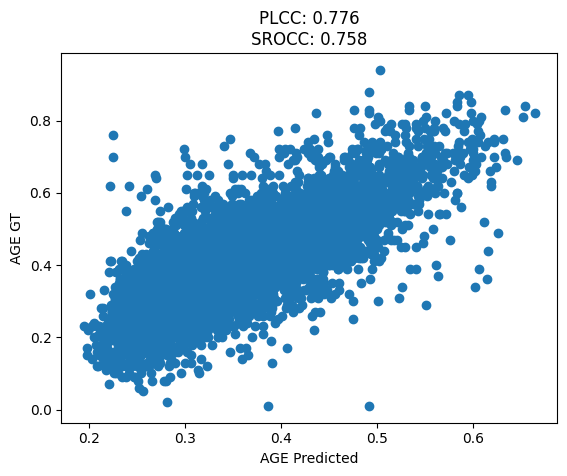

2, [16, 169] loss: 0.0634	PLCC: 0.775	SROCC: 0.750	lr: 0.000971
2, [32, 169] loss: 0.0582	PLCC: 0.798	SROCC: 0.782	lr: 0.000966
2, [48, 169] loss: 0.0568	PLCC: 0.819	SROCC: 0.798	lr: 0.000960
2, [64, 169] loss: 0.0568	PLCC: 0.810	SROCC: 0.781	lr: 0.000954
2, [80, 169] loss: 0.0589	PLCC: 0.804	SROCC: 0.789	lr: 0.000948
2, [96, 169] loss: 0.0622	PLCC: 0.768	SROCC: 0.741	lr: 0.000941
2, [112, 169] loss: 0.0572	PLCC: 0.819	SROCC: 0.805	lr: 0.000934
2, [128, 169] loss: 0.0562	PLCC: 0.821	SROCC: 0.809	lr: 0.000926
2, [144, 169] loss: 0.0572	PLCC: 0.816	SROCC: 0.803	lr: 0.000919
2, [160, 169] loss: 0.0583	PLCC: 0.815	SROCC: 0.802	lr: 0.000910
Validation loss: 0.063637	PLCC: 0.810	SROCC: 0.790


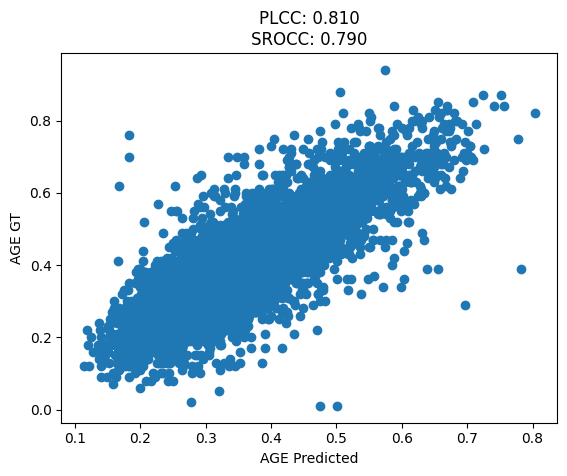

3, [16, 169] loss: 0.0574	PLCC: 0.812	SROCC: 0.786	lr: 0.000897
3, [32, 169] loss: 0.0588	PLCC: 0.804	SROCC: 0.784	lr: 0.000887
3, [48, 169] loss: 0.0588	PLCC: 0.813	SROCC: 0.788	lr: 0.000878
3, [64, 169] loss: 0.0568	PLCC: 0.827	SROCC: 0.821	lr: 0.000868
3, [80, 169] loss: 0.0546	PLCC: 0.843	SROCC: 0.819	lr: 0.000858
3, [96, 169] loss: 0.0528	PLCC: 0.842	SROCC: 0.827	lr: 0.000847
3, [112, 169] loss: 0.0540	PLCC: 0.822	SROCC: 0.810	lr: 0.000837
3, [128, 169] loss: 0.0527	PLCC: 0.835	SROCC: 0.821	lr: 0.000826
3, [144, 169] loss: 0.0541	PLCC: 0.835	SROCC: 0.824	lr: 0.000814
3, [160, 169] loss: 0.0517	PLCC: 0.845	SROCC: 0.832	lr: 0.000803
Validation loss: 0.053995	PLCC: 0.826	SROCC: 0.807


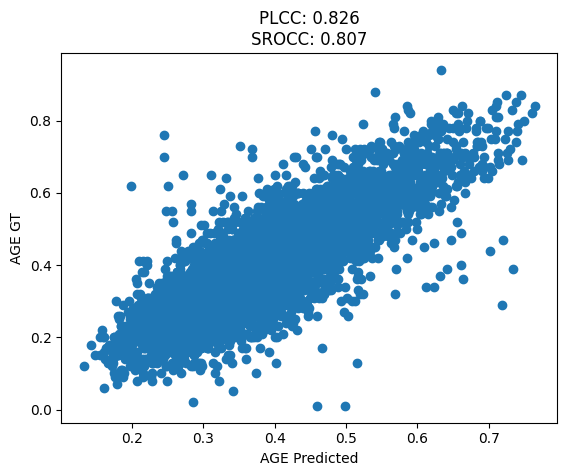

4, [16, 169] loss: 0.0502	PLCC: 0.849	SROCC: 0.838	lr: 0.000784
4, [32, 169] loss: 0.0493	PLCC: 0.866	SROCC: 0.848	lr: 0.000772
4, [48, 169] loss: 0.0513	PLCC: 0.848	SROCC: 0.844	lr: 0.000759
4, [64, 169] loss: 0.0523	PLCC: 0.849	SROCC: 0.839	lr: 0.000746
4, [80, 169] loss: 0.0510	PLCC: 0.850	SROCC: 0.846	lr: 0.000733
4, [96, 169] loss: 0.0491	PLCC: 0.853	SROCC: 0.838	lr: 0.000720
4, [112, 169] loss: 0.0519	PLCC: 0.848	SROCC: 0.833	lr: 0.000707
4, [128, 169] loss: 0.0488	PLCC: 0.867	SROCC: 0.849	lr: 0.000693
4, [144, 169] loss: 0.0460	PLCC: 0.878	SROCC: 0.859	lr: 0.000680
4, [160, 169] loss: 0.0449	PLCC: 0.885	SROCC: 0.872	lr: 0.000666
Validation loss: 0.055469	PLCC: 0.840	SROCC: 0.820


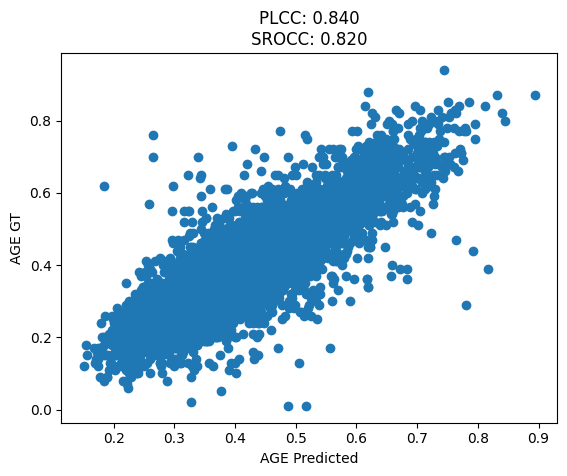

5, [16, 169] loss: 0.0418	PLCC: 0.904	SROCC: 0.896	lr: 0.000644
5, [32, 169] loss: 0.0460	PLCC: 0.882	SROCC: 0.875	lr: 0.000630
5, [48, 169] loss: 0.0460	PLCC: 0.872	SROCC: 0.864	lr: 0.000615
5, [64, 169] loss: 0.0449	PLCC: 0.879	SROCC: 0.866	lr: 0.000601
5, [80, 169] loss: 0.0440	PLCC: 0.888	SROCC: 0.882	lr: 0.000587
5, [96, 169] loss: 0.0440	PLCC: 0.889	SROCC: 0.882	lr: 0.000572
5, [112, 169] loss: 0.0446	PLCC: 0.881	SROCC: 0.864	lr: 0.000557
5, [128, 169] loss: 0.0428	PLCC: 0.896	SROCC: 0.883	lr: 0.000543
5, [144, 169] loss: 0.0456	PLCC: 0.882	SROCC: 0.868	lr: 0.000528
5, [160, 169] loss: 0.0464	PLCC: 0.869	SROCC: 0.857	lr: 0.000513
Validation loss: 0.056571	PLCC: 0.844	SROCC: 0.827


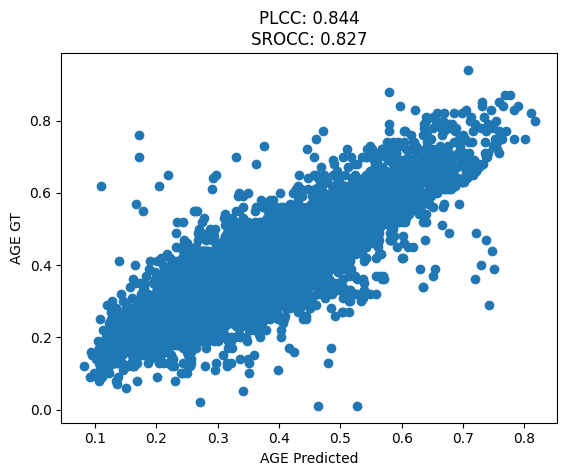

6, [16, 169] loss: 0.0403	PLCC: 0.906	SROCC: 0.892	lr: 0.000490
6, [32, 169] loss: 0.0375	PLCC: 0.919	SROCC: 0.912	lr: 0.000476
6, [48, 169] loss: 0.0412	PLCC: 0.893	SROCC: 0.889	lr: 0.000461
6, [64, 169] loss: 0.0431	PLCC: 0.891	SROCC: 0.888	lr: 0.000446
6, [80, 169] loss: 0.0394	PLCC: 0.913	SROCC: 0.896	lr: 0.000432
6, [96, 169] loss: 0.0395	PLCC: 0.904	SROCC: 0.889	lr: 0.000417
6, [112, 169] loss: 0.0405	PLCC: 0.901	SROCC: 0.890	lr: 0.000403
6, [128, 169] loss: 0.0399	PLCC: 0.902	SROCC: 0.898	lr: 0.000388
6, [144, 169] loss: 0.0399	PLCC: 0.909	SROCC: 0.897	lr: 0.000374
6, [160, 169] loss: 0.0423	PLCC: 0.889	SROCC: 0.885	lr: 0.000360
Validation loss: 0.053139	PLCC: 0.853	SROCC: 0.834


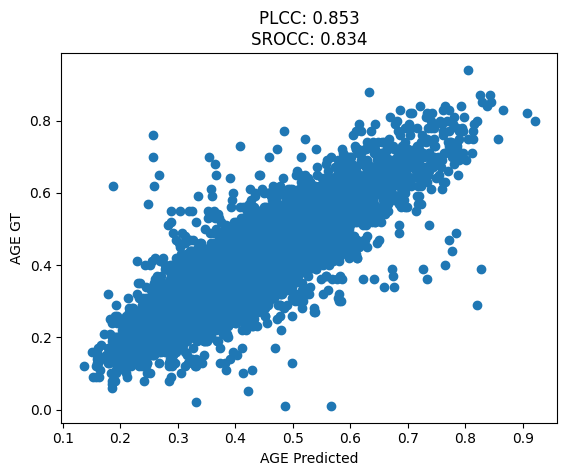

7, [16, 169] loss: 0.0415	PLCC: 0.906	SROCC: 0.892	lr: 0.000338
7, [32, 169] loss: 0.0375	PLCC: 0.924	SROCC: 0.912	lr: 0.000324
7, [48, 169] loss: 0.0366	PLCC: 0.910	SROCC: 0.906	lr: 0.000311
7, [64, 169] loss: 0.0359	PLCC: 0.926	SROCC: 0.920	lr: 0.000297
7, [80, 169] loss: 0.0357	PLCC: 0.928	SROCC: 0.927	lr: 0.000284
7, [96, 169] loss: 0.0353	PLCC: 0.922	SROCC: 0.919	lr: 0.000271
7, [112, 169] loss: 0.0340	PLCC: 0.926	SROCC: 0.921	lr: 0.000258
7, [128, 169] loss: 0.0368	PLCC: 0.914	SROCC: 0.909	lr: 0.000245
7, [144, 169] loss: 0.0364	PLCC: 0.912	SROCC: 0.912	lr: 0.000233
7, [160, 169] loss: 0.0367	PLCC: 0.919	SROCC: 0.910	lr: 0.000221
Validation loss: 0.049121	PLCC: 0.858	SROCC: 0.841


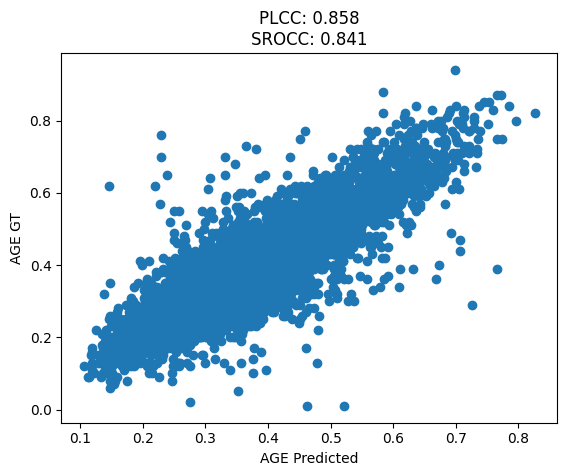

8, [16, 169] loss: 0.0334	PLCC: 0.927	SROCC: 0.923	lr: 0.000202
8, [32, 169] loss: 0.0322	PLCC: 0.930	SROCC: 0.929	lr: 0.000191
8, [48, 169] loss: 0.0321	PLCC: 0.931	SROCC: 0.923	lr: 0.000180
8, [64, 169] loss: 0.0295	PLCC: 0.943	SROCC: 0.937	lr: 0.000169
8, [80, 169] loss: 0.0323	PLCC: 0.939	SROCC: 0.932	lr: 0.000158
8, [96, 169] loss: 0.0306	PLCC: 0.940	SROCC: 0.935	lr: 0.000148
8, [112, 169] loss: 0.0337	PLCC: 0.932	SROCC: 0.925	lr: 0.000138
8, [128, 169] loss: 0.0329	PLCC: 0.932	SROCC: 0.931	lr: 0.000128
8, [144, 169] loss: 0.0311	PLCC: 0.931	SROCC: 0.929	lr: 0.000118
8, [160, 169] loss: 0.0306	PLCC: 0.944	SROCC: 0.940	lr: 0.000109
Validation loss: 0.046273	PLCC: 0.861	SROCC: 0.845


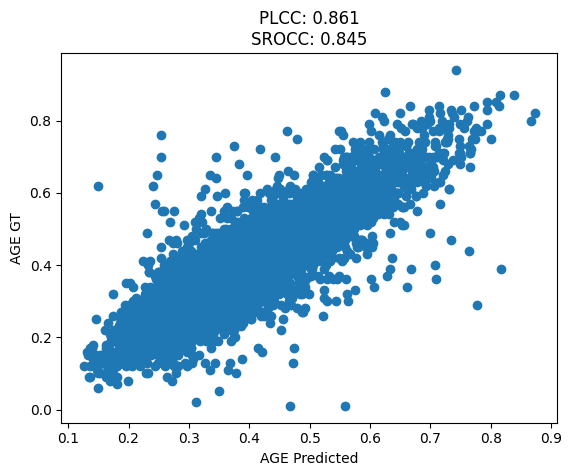

9, [16, 169] loss: 0.0283	PLCC: 0.944	SROCC: 0.945	lr: 0.000096
9, [32, 169] loss: 0.0283	PLCC: 0.945	SROCC: 0.944	lr: 0.000088
9, [48, 169] loss: 0.0293	PLCC: 0.946	SROCC: 0.942	lr: 0.000080
9, [64, 169] loss: 0.0297	PLCC: 0.948	SROCC: 0.941	lr: 0.000073
9, [80, 169] loss: 0.0285	PLCC: 0.938	SROCC: 0.939	lr: 0.000066
9, [96, 169] loss: 0.0297	PLCC: 0.940	SROCC: 0.935	lr: 0.000059
9, [112, 169] loss: 0.0266	PLCC: 0.952	SROCC: 0.947	lr: 0.000053
9, [128, 169] loss: 0.0284	PLCC: 0.945	SROCC: 0.945	lr: 0.000047
9, [144, 169] loss: 0.0282	PLCC: 0.945	SROCC: 0.937	lr: 0.000042
9, [160, 169] loss: 0.0294	PLCC: 0.937	SROCC: 0.932	lr: 0.000037
Validation loss: 0.046328	PLCC: 0.863	SROCC: 0.846


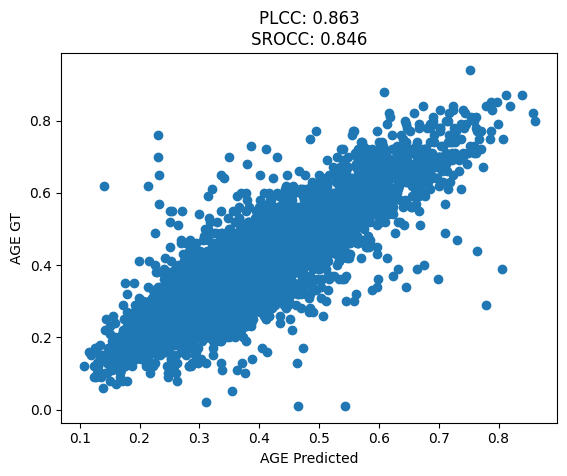

10, [16, 169] loss: 0.0262	PLCC: 0.948	SROCC: 0.943	lr: 0.000030
10, [32, 169] loss: 0.0256	PLCC: 0.957	SROCC: 0.953	lr: 0.000026
10, [48, 169] loss: 0.0262	PLCC: 0.953	SROCC: 0.949	lr: 0.000022
10, [64, 169] loss: 0.0275	PLCC: 0.944	SROCC: 0.940	lr: 0.000019
10, [80, 169] loss: 0.0283	PLCC: 0.947	SROCC: 0.944	lr: 0.000017
10, [96, 169] loss: 0.0265	PLCC: 0.957	SROCC: 0.953	lr: 0.000015
10, [112, 169] loss: 0.0265	PLCC: 0.948	SROCC: 0.946	lr: 0.000013
10, [128, 169] loss: 0.0259	PLCC: 0.950	SROCC: 0.952	lr: 0.000011
10, [144, 169] loss: 0.0283	PLCC: 0.945	SROCC: 0.945	lr: 0.000011
10, [160, 169] loss: 0.0245	PLCC: 0.952	SROCC: 0.952	lr: 0.000010
Validation loss: 0.046185	PLCC: 0.863	SROCC: 0.847


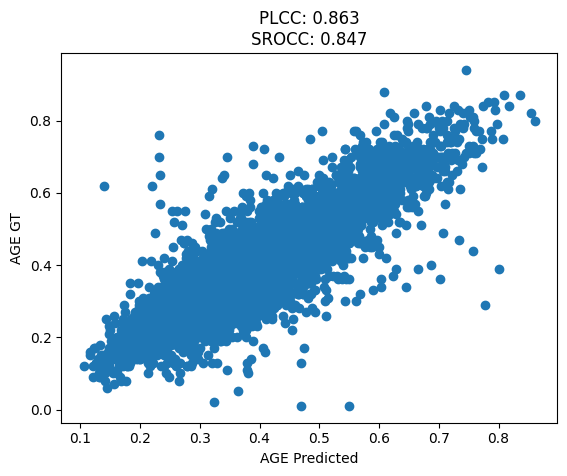

Finished Training


In [13]:

# Training loop
for epoch in range(epochs):  # Loop over the dataset for multiple epochs
    running_loss = []  # List to store training loss for each batch
    gt_labels = []  # List to store ground truth labels (predicted age)
    pr_labels = []  # List to store predicted labels (model output)

    net.train()  # Set the model to training mode (enables dropout and other training-specific behaviors)

    for i, data in enumerate(trainloader):
        # Get inputs and labels from the data loader
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.cpu().numpy())   # Append ground truth

        inputs = inputs.to(device)  # Move data to the appropriate device (CPU or GPU)
        labels = labels.to(device)  # Move labels to the appropriate device

        # Zero the parameter gradients before each backward pass
        optimizer.zero_grad()

        # Forward pass, calculate loss
        outputs = net(inputs)  # Get model predictions

        loss = criterion(outputs.squeeze(), labels)  # Calculate L1 loss between predictions and true labels
        pr_labels.append(outputs.squeeze().detach().cpu())  # Store predictions (detach to avoid gradients)

        # Backward pass and parameter update
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights based on gradients
        scheduler.step()  # Update learning rate according to the scheduler

        # Print statistics (every 10% of the training data)
        running_loss.append(loss.item())
        if (i + 1) % (len(trainloader) // 10) == 0:  # Every 10% of the epoch
            gt_labels = np.stack(list(itertools.chain.from_iterable(gt_labels))).squeeze()  # Combine ground truth labels
            pr_labels = np.stack(list(itertools.chain.from_iterable(pr_labels))).squeeze()  # Combine predictions

            # Calculate and print performance metrics (PLCC, SROCC, learning rate)
            s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
            p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
            print('%d, [%d, %d] loss: %.4f\tPLCC: %.3f\tSROCC: %.3f\tlr: %.6f' %
                  (epoch + 1, i + 1, len(trainloader), np.mean(running_loss), p, s, optimizer.param_groups[-1]['lr']))

            # Clear lists for next iteration within the epoch
            gt_labels = []
            pr_labels = []
            running_loss = []

    # Validation loop (after each training epoch)
    running_loss = []  # List to store validation loss for each batch
    gt_labels = []  # List to store ground truth labels (predicted age)
    pr_labels = []  # List to store predicted labels (model output)

    net.eval()  # Set the model to evaluation mode (deactivates dropout and other training behaviors)

    for i, data in enumerate(valloader):
        # Get inputs and labels from the data loader
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.item())  # Append ground truth as single values

        inputs = inputs.to(device)  # Move data to the appropriate device
        labels = labels.to(device)  # Move labels to the appropriate device

        # Forward pass with gradient suppression
        with torch.no_grad():
            outputs = net(inputs)  # Get model predictions without calculating gradients

        pr_labels.append(outputs.squeeze().item())  # Append predictions as single values
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Calculate L1 loss
        running_loss.append(loss.item())

    # Calculate and print validation performance metrics
    gt_labels = np.stack(gt_labels)  # Combine ground truth labels
    pr_labels = np.stack(pr_labels)  # Combine predictions
    s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
    p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
    print('Validation loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

    # Visualization (optional)
    plt.scatter(pr_labels, gt_labels)
    plt.xlabel("AGE Predicted")
    plt.ylabel("AGE GT")
    plt.title("PLCC: %.3f\nSROCC: %.3f" % (p, s))
    plt.show()

    # Save the model (optional)
    if epoch == 9:
        torch.save(net.state_dict(), f"models/{net_name}_only_fc_layer_4_layer_3_layer_2_layer_1_unfrozen_epoch_{epoch}.pth")  # Save model state after each epoch

print('Finished Training')


Evaluate on the test-set

Test loss: 0.046277	PLCC: 0.871	SROCC: 0.855


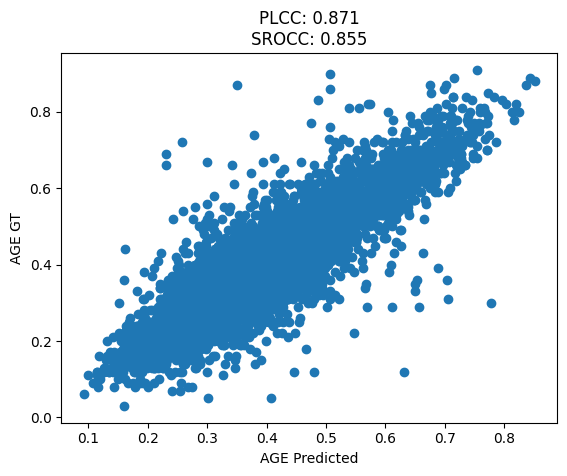

In [14]:
# Testing loop (after training)
running_loss = []  # List to store test loss for each batch
gt_labels = []  # List to store ground truth labels (predicted age)
pr_labels = []  # List to store predicted labels (model output)

# net = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')  # Load pre-trained weights
# num_ftrs = net.classifier[1].in_features  # Get the number of input features for the last layer
# net.classifier = nn.Sequential(
#     nn.Linear(num_ftrs, 512),  # First linear layer with 512 units
#     nn.ReLU(),  # GELU activation function
#     nn.Linear(512, 32),  # Second linear layer with 32 units
#     nn.GELU(),  # GELU activation function
#     nn.Linear(32, 1)   # Output layer with 1 unit (for age prediction)
# )

# # Load the checkpoint
# net.load_state_dict(torch.load('models/MobileNetV2_only_fc_unfrozen_epoch_9.pth'))

# print(net.__class__.__name__)
# net.to(device)

net.eval()  # Set the model to evaluation mode (deactivates dropout and other training behaviors)

for i, data in enumerate(testloader):
    # Get inputs and labels from the data loader
    inputs, labels = data["image"], data["age"]
    gt_labels.append(labels.item())  # Append ground truth as single values

    inputs = inputs.to(device)  # Move data to the appropriate device
    labels = labels.to(device)  # Move labels to the appropriate device

    # Forward pass with gradient suppression
    with torch.no_grad():
        outputs = net(inputs)  # Get model predictions without calculating gradients

    pr_labels.append(outputs.squeeze().item())  # Append predictions as single values
    loss = criterion(outputs.squeeze(), labels.squeeze())  # Calculate L1 loss
    running_loss.append(loss.item())

# Calculate and print test performance metrics
gt_labels = np.stack(gt_labels)  # Combine ground truth labels
pr_labels = np.stack(pr_labels)  # Combine predictions
s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
print('Test loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

# Visualization (optional)
plt.scatter(pr_labels, gt_labels)
plt.xlabel("AGE Predicted")
plt.ylabel("AGE GT")
plt.title("PLCC: %.3f\nSROCC: %.3f" % (p, s))
plt.show()

**!ASSIGNMENT!**

*Transfer learning*
1. Finetune all the layers of the current network (mobilenet_v2).
2. Swap out the current model with a new one from [here](https://pytorch.org/vision/main/models.html#classification) that is already trained on Imagenet. Then, fine-tune the network and compare how well it performs on the test-set compared to the current network (mobilenet_v2) using PLCC and SROCC metrics.